In [124]:
import autograd.numpy as np
from autograd import grad, hessian
import matplotlib.pyplot as plt
from sklearn.metrics import accuracy_score

from tqdm import tqdm #optional, if you do not want to import remove tqdm() from loops!

%load_ext autoreload
%autoreload 2
%matplotlib inline

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


# 1. Preprocessing

We again will be using the MNIST dataset. This time I prepared the dataset as a npy file. We will load the data visualize an example and the implement logistic regression.

In [125]:
# change if the file is in a different directory
f_features = "features.npy"

# change if the file is in a different directory
f_labels = "labels.npy"

# load the data
features=np.load(f_features)
labels=np.load(f_labels)

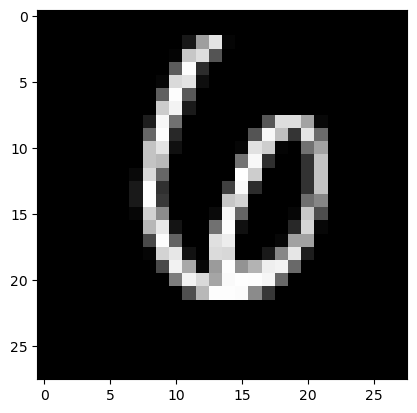

In [126]:
plt.imshow(features[0,:,:], cmap='gray')

In [127]:
# As you know we need to split the data into training, validation and test
x_train=features[0:4800,:,:]
x_train=x_train.reshape((4800, 784))
y_train=labels[0:4800].astype(int)

x_val=features[4800:5400,:,:]
x_val=x_val.reshape((600, 784))
y_val=labels[4800:5400].astype(int)

x_test=features[5400:6000,:,:]
x_test=x_test.reshape((600, 784))
y_test=labels[5400:6000].astype(int)

# Note: Normally the split has to be random and stratified for the validation set and random for the test set

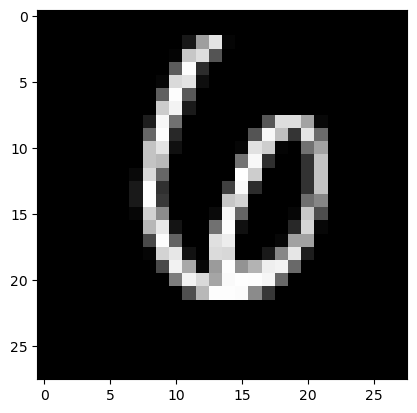

In [128]:
plt.imshow(x_train[0].reshape(28,28), cmap='gray')

# 2. Logistic Regression

From the lecture we know that logistic regression is given by affined transformation of the data followed by applying the sigmoid function. Our first step is to implement the function we need.

In [129]:
def layer(x, w):
    """
    

    Parameters
    ----------
    x : feature tensor of dimension (N,M)
    w : learnable parameters of dimension (M+1, C)

    N is the number of samples, M the number of features and C the number of classes.

    Returns
    -------
    res : output tensor of dimension (N, C) 

    res should be the result of the matrix multiplication of an expanded feature tensor (1 column) with 
    the learnable parameters.

    """
    
    
    res=0
    # TODO
    # Implement the affine transformation
    # Put your code here:
    bias_column = np.ones((x.shape[0], 1))
    x = np.hstack((bias_column, x))
    res = np.matmul(x, w)

    
    # END
    
    return res

In [130]:
# test your code

w=np.ones((28*28+1,10)) # 28*28 are the number of features and the bias leads to +1
res=layer(x_train, w)
res.shape

(4800, 10)

In [131]:
# If you need more function use the blocks below


## 2.1 Loss Function
In exercise sheet 0, we just guessed values, but now we are smarter! First we need to define an appropriate loss function. The dataset has ten target classes, so we want to implement cross-entropy loss:

$\mathcal{L}=\sum_{y}1\{\hat{y}=y\}(-\log[p(y)])$ 

The $p(y)$ is given by the softmax function

$p(y_i)=\frac{e^{x_i}}{\sum_ie^{x_i}}$

So the softmax should return a vector representing the probability of each class.

In [132]:
def softmax(y):
    """
    

    Parameters
    ----------
    y : Prediction tensor of dimension (N, C). 

    Returns
    -------
    res : Softmax transformed tensor of dimension (N,C)

    res should be the result of the softmax transformation of y.

    """
    
    res=0
    # TODO 
    # Implement the softmax function
    # Put your code here:
    N = y.shape[0]
    C = y.shape[1]
    res=np.zeros((N, C))
    for i in range(N):
        y_max = np.max(y[i])  # Log Sum Trick
        exp_values = np.exp(y[i] - y_max)
        divisor = np.sum(exp_values)
        res[i] = exp_values / divisor 
    # END
    return res

In [133]:
def model(x, w):
    """
    
    Parameters
    ----------
    x : feature tensor of dimension (N,M)
    w : learnable parameters of dimension (M+1, C)

    N is the number of samples, M the number of features and C the number of classes.

    Returns
    -------
    res : Prediction tensor of dimension (N,1)

    res should be the classification of our model 

    """
    
    
    res=0
    # TODO
    # Put your code here:
    N = x.shape[0]
    res_temp = layer(x, w)
    res_temp = softmax(res_temp)
    res = np.argmax(res_temp, axis=1)
    # END
    
    return res

In [134]:
# If you need more function use the blocks below

## 2.2 Optimization
We have already learned about optimization algorithms. In this exercise we want to learn more about gradient descent, stochastic gradient descent and Newton’s method.

### 2.2.1 Gradient Descent
For gradient descent we need to updates our parameters using the steepest descent of the gradient with respect to the parameter. It is given by the equation:

$w_{n+1}=w_n-\epsilon_n\nabla\mathcal{L(w_n)}$

$\epsilon_n$ is the learning rate and a hyperparameter of our optimization approach. We can calculate the gradient by using the composition rule for derivatives.

The challenge is to broadcast the right dimensions!

In [135]:
def classTensor(y, C):
    """
    
    Parameters
    ----------
    y : class vector of dimension N containing the true classes
    C : number of classes


    Returns
    -------
    res : class tensor of dimension (N,C)

    We want to transform the vector into a binary tensor. If res_ij=1 then it means that at sample i we have class j. Otherwise 
    res_ij=0.

    """  


    res=0
    # TODO
    # Implement the tensor transformation
    # Put your code here:
    N = y.shape[0]
    C = C
    res = np.zeros((N, C))
    res[np.arange(N), y] = 1

    
    # END

    return res

In [136]:
def gradientDescent(x, y, w, learningRate):
    """
    
    Parameters
    ----------
    x : feature tensor of dimension (N,M)
    y : class vector of dimension N containing the true classes
    w : learnable parameters of dimension (M+1, C)

    N is the number of samples, M the number of features and C the number of classes.

    Returns
    -------
    res : updated learnable parameters

    """
    res=0
    # TODO 
    # Implement one update iteration
    
    C = w.shape[1]
    y_one_hot = classTensor(y, C) 
    bias_column = np.ones((x.shape[0], 1))
    x_1 = np.hstack((bias_column, x))
    logits = layer(x, w)
    probabilities = softmax(logits)    
    gradient = x_1.T @ (probabilities - y_one_hot) 
    res = w - learningRate * gradient
    
    # C = w.shape[1]
    # y = classTensor(y, C)
    # bias_column = np.ones((x.shape[0], 1))
    # x_1 = np.hstack((bias_column, x))
    # res = w - learningRate*(x_1.T@(y-softmax(layer(x, w))))
    
    

    return res

In [137]:
# If you need more function use the blocks below

### 2.2.2 Stochastic Gradient Descent
In this section implement stochastic gradient descent by writing the function "def stochasticGradientDescent(...)"

In [138]:
# TODO
# Write the function stochasticGradientDescent

In [139]:
def stochasticOneHot(y, C):
    one_hot = np.zeros((1, C))
    one_hot[0, y] = 1
    return one_hot

In [140]:
def stochasticGradientDescent(x, y, w, learningRate):
    
    
    C = w.shape[1]
    N = x.shape[0]
    
    random_index = np.random.choice(N)
    sample_x = x[random_index]
    sample_y = y[random_index]
    y_one_hot = stochasticOneHot(sample_y, C) 
    
    sample_x = np.append(sample_x, 1).reshape(1, -1)
    
    logits = sample_x@w
    probabilities = softmax(logits) 
    
    gradient = sample_x.T @ (probabilities - y_one_hot)
    res = w - learningRate * gradient
    
    
    return res

### 2.2.3 Newton’s method
In this section implement Newton's method by writing the function "def newtonMethod(...)"

In [155]:
# TODO
# Write the function newtonMethod

In [156]:
def newtonMethod(x, y, w):
    res = 0
    
    C = w.shape[1]
    N = x.shape[0]
    M = x.shape[1]
    y = classTensor(y, C)
    bias_column = np.ones((x.shape[0], 1))
    x_1 = np.hstack((bias_column, x))  
    
    logits = layer(x, w)
    probabilities = softmax(logits) 
    
    # Hesse Matrix size M+1 x M+1
    H = np.zeros((M+1, M+1))

    for i in range(N):
        s_i = probabilities[i].reshape(-1, 1)  
        x_i = x_1[i].reshape(-1, 1)  
        softmax_hessian = np.diagflat(s_i) - s_i @ s_i.T  
        H += x_i @ x_i.T * softmax_hessian.sum()  
    
    gradient = x_1.T @ (probabilities - y)
    epsilon = 0.001  # Numerical stability
    hess_inv = np.linalg.inv(H + epsilon * np.eye(H.shape[0]))

    
    res = w - hess_inv @ gradient
    
    return res

# 3. Training
Now use the MNIST dataset to train a classifier and compare the results.

# 3.1 Train and Plot Gradient Descent

In [145]:
acc_train=[]
acc_val=[]

n_epochs=100
learningRate=0.001

# Maybe you find a better way to initialize the learnable parameters
w=np.zeros((785,10))+1

for e in tqdm(range(n_epochs)):

    w=gradientDescent(x_train,y_train, w,learningRate)
    pred=model(x_train,w)

    acc_train.append(accuracy_score(y_train, pred))
    acc_val.append(accuracy_score(y_val, model(x_val,w)))

100%|██████████| 100/100 [00:11<00:00,  8.41it/s]


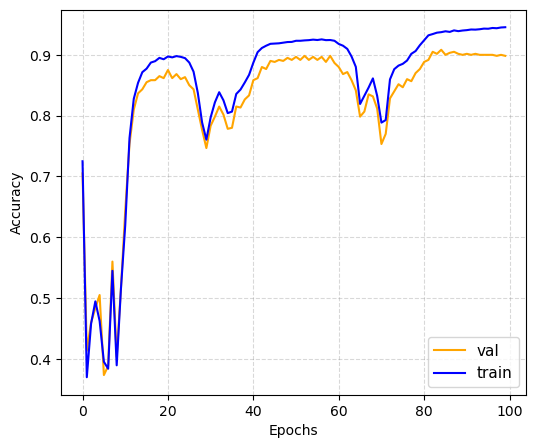

In [146]:
fig, ax = plt.subplots(figsize=(6, 5))


ax.set_xlabel("Epochs")
ax.set_ylabel("Accuracy")

ax.plot(acc_val, c="orange", label="val", lw=1.5)
ax.plot(acc_train, c="blue", label="train",lw=1.5)
ax.grid(color='gray', linestyle='dashed', alpha=0.3)
ax.legend(loc="lower right", fontsize=11)

## 3.2 TODO: Implement training for stochastic gradient descent

In [147]:
acc_train=[]
acc_val=[]

n_epochs=1000
learningRate=0.001

# Maybe you find a better way to initialize the learnable parameters
w=np.zeros((785,10))+1

for e in tqdm(range(n_epochs)):

    w=stochasticGradientDescent(x_train, y_train, w, learningRate)
    pred=model(x_train,w)

    acc_train.append(accuracy_score(y_train, pred))
    acc_val.append(accuracy_score(y_val, model(x_val,w)))

100%|██████████| 1000/1000 [01:02<00:00, 16.02it/s]


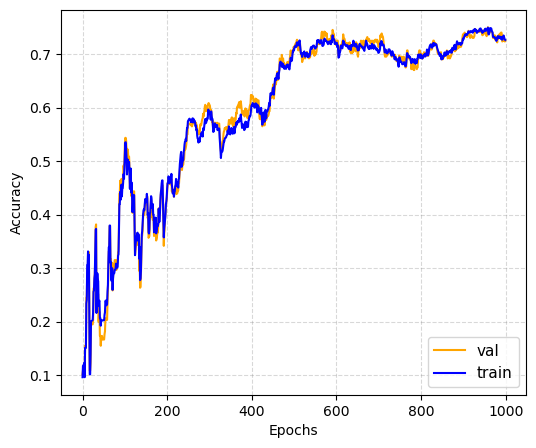

In [148]:
fig, ax = plt.subplots(figsize=(6, 5))


ax.set_xlabel("Epochs")
ax.set_ylabel("Accuracy")

ax.plot(acc_val, c="orange", label="val", lw=1.5)
ax.plot(acc_train, c="blue", label="train",lw=1.5)
ax.grid(color='gray', linestyle='dashed', alpha=0.3)
ax.legend(loc="lower right", fontsize=11)

## 3.3 TODO: Implement training for newton's method

In [157]:
acc_train=[]
acc_val=[]

n_epochs=50

# Maybe you find a better way to initialize the learnable parameters
w=np.zeros((785,10))+1

for e in tqdm(range(n_epochs)):

    w=newtonMethod(x_train,y_train, w)
    pred=model(x_train,w)

    acc_train.append(accuracy_score(y_train, pred))
    acc_val.append(accuracy_score(y_val, model(x_val,w)))

100%|██████████| 50/50 [05:04<00:00,  6.10s/it]


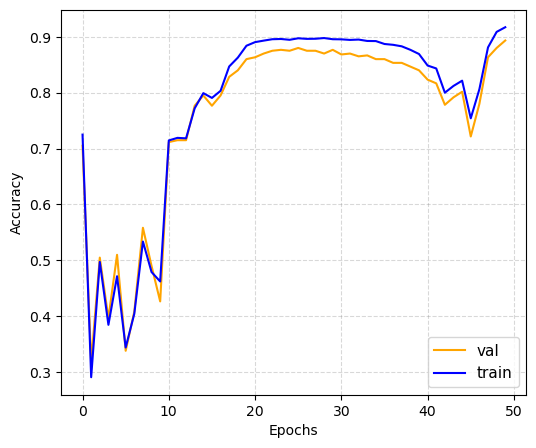

In [158]:
fig, ax = plt.subplots(figsize=(6, 5))


ax.set_xlabel("Epochs")
ax.set_ylabel("Accuracy")

ax.plot(acc_val, c="orange", label="val", lw=1.5)
ax.plot(acc_train, c="blue", label="train",lw=1.5)
ax.grid(color='gray', linestyle='dashed', alpha=0.3)
ax.legend(loc="lower right", fontsize=11)